In [1]:
import os
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

# Reading Data using Pandas and SQLite3

In [2]:
# helper function to join tables across different database (.db) files
def join_tables(tables):
    
    df = tables[0]
    for table in tables[1:]:
        df = pd.concat([df, table])
        
    return df.reset_index(drop=True)

# joining all database (.db) files of folder
def get_all_databases(folder):
    
    string_tables = []
    ull_tables = []
    files = os.listdir(folder)
    
    # iterating through all files of folder to append tables
    for file in files:
        path = os.path.join(folder, file)
        con = sqlite3.connect(path)
        string_tables.append(pd.read_sql_query('SELECT COUNTERS_STRING_TIME_DATA.*, INPUTS.INPUT_DESCRIPTION FROM COUNTERS_STRING_TIME_DATA LEFT JOIN INPUTS WHERE COUNTERS_STRING_TIME_DATA.ID_INPUT == INPUTS.ID_INPUT', con))
        ull_tables.append(pd.read_sql_query('SELECT COUNTERS_ULL_TIME_DATA.*, INPUTS.INPUT_DESCRIPTION FROM COUNTERS_ULL_TIME_DATA LEFT JOIN INPUTS WHERE COUNTERS_ULL_TIME_DATA.ID_INPUT == INPUTS.ID_INPUT', con))
        
    # concatenating tables into single DataFrames
    string_df = join_tables(string_tables)
    string_df.loc[:, 'VALUE'] = string_df.loc[:, 'VALUE'].replace({'WWAHost.exe': 'Netflix.exe'}) 
    string_df.loc[:, 'VALUE'] = string_df.loc[:, 'VALUE'].str.lower()
    string_df.loc[string_df['INPUT_DESCRIPTION'] == 'Mouse cursor icon state.', 'ID_INPUT'] = 2
    string_df.loc[string_df['INPUT_DESCRIPTION'] == 'Foreground window .exe process.', 'ID_INPUT'] = 3
    ull_df = join_tables(ull_tables)
    ull_df.loc[ull_df['INPUT_DESCRIPTION'] == 'Mouse X position in pixel(s)', 'ID_INPUT'] = 0
    ull_df.loc[ull_df['INPUT_DESCRIPTION'] == 'Mouse Y position in pixel(s)', 'ID_INPUT'] = 1
    ull_df.loc[ull_df['INPUT_DESCRIPTION'] == 'Foreground window is immersive.', 'ID_INPUT'] = 4
    ull_df.loc[ull_df['INPUT_DESCRIPTION'] == 'Foreground window is hung.', 'ID_INPUT'] = 5
    return (string_df.drop('INPUT_DESCRIPTION', axis=1), ull_df.drop('INPUT_DESCRIPTION', axis=1))
    
    return (string_df, ull_df)

In [3]:
def clean(df, condition_1=True):
    
    sequence = df[df['ID_INPUT'] == 3]['VALUE'].values
    pairs = []
    
    for i in range(len(sequence)-1):
        if condition_1 == True:
            if sequence[i] == sequence[i+1]:
                continue
            else:
                pairs.append([sequence[i], sequence[i+1]])
        else:
            pairs.append([sequence[i], sequence[i+1]])
        
    return pd.DataFrame(pairs, columns=['X', 'y'])

class first_order_HMM(object):
    
    def __init__(self, computer=0):
        if computer == 0:
            self.uniques = sorted(string_df_0[string_df_0['ID_INPUT'] == 3]['VALUE'].unique())
        else:
            self.uniques = sorted(string_df_1[string_df_1['ID_INPUT'] == 3]['VALUE'].unique())
        self.data = pd.DataFrame()
        self.counts = defaultdict(float)
        self.priors = defaultdict(float)
        self.posteriors = defaultdict(float)

    def fit(self, X, y):
        """
        inputs :
            X : a list of prior foreground applications
            y : a list of subsequent foreground applications from the prior foreground applications
            
        outputs:
            None
        """
        
        self.data = pd.DataFrame({'X': X, 'y': y})
        
        def get_counts():
            counts = defaultdict(float)
            for foreground in self.data.values:
                counts[foreground[0]] += 1
            counts[self.data.values[-1][1]] += 1
            return pd.Series(dict(sorted(counts.items())))
        
        def get_priors():
            priors = defaultdict(float)
            # getting percentage of each unique foreground's occurrence
            for foreground, count in self.counts.items():
                priors[foreground] = count / (len(self.data.values) + 1)
            return pd.Series(priors)

        def get_posteriors():
            # creating empty conditional probability matrix
            posteriors = pd.DataFrame(
                np.zeros([len(self.uniques), len(self.uniques)]), 
                index=self.uniques, 
                columns=self.uniques
            )           
            # counting pairs of foregrounds
            for pair in self.data.values:
                posteriors.loc[pair[0], pair[1]] += 1
            # calculating conditional probability of foreground A given foreground B
            posteriors = posteriors.apply(lambda x: x / sum(x), axis=1)
            return posteriors
        
        self.counts = get_counts()
        self.priors = get_priors()
        self.posteriors = get_posteriors()
    
    def predict(self, X, n_foregrounds=1):
        """
        inputs :
            X : a list of prior foreground applications
            n_foregrounds : number of predicted foregrounds to return (default: 1)
            
        outputs :
            y : a list of predicted subsequent foreground applications 
        """
        
        # outputting foreground application with maximum conditional probability
        y = []
        for x in X:
            # outputting foreground application with maximum conditional probability
            # y = np.append(y, self.posteriors.loc[x,:].idxmax())
            y.append(list(self.posteriors.loc[x,:].sort_values(ascending=False)[:n_foregrounds].index))
            
        return y
            
    def accuracy(self, y_test, y_pred):
        """
        inputs :
            y_test : a list of true subsequent foreground applications
            y_pred : a list of predicted subsequent foreground applications
            
        outputs :
            accuracy : accuracy of trained model on y_test
        """
        correct = 0
        for i, y in enumerate(y_test):
            if y in y_pred[i]:
                correct += 1
        accuracy = correct / len(y_test)
        
        return accuracy

# Problem 2
Predict the total time an application is used in the foreground.

### Problem 2a

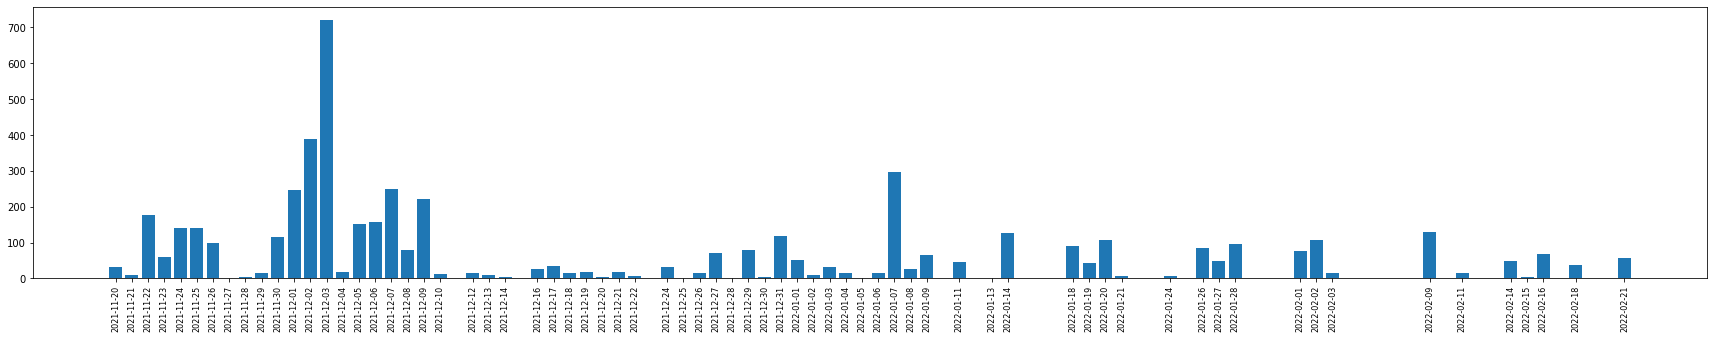

In [34]:
string_df_0, ull_df_0 = get_all_databases('group3_collected_data')

string_df_0['MEASUREMENT_TIME'] = string_df_0['MEASUREMENT_TIME'].apply(lambda x: pd.to_datetime(x).date())
foreground_0 = string_df_0[string_df_0['ID_INPUT'] == 3].groupby('MEASUREMENT_TIME').agg('count')['VALUE']
plt.figure(figsize=(30,5))
plt.bar(x=foreground_0.index, height=foreground_0.values)
plt.xticks(ticks=foreground_0.index, rotation=90, fontsize=8);

In [68]:
string_df_0[string_df_0['ID_INPUT'] == 3]['VALUE'].value_counts()

chrome.exe                              1526
explorer.exe                             945
discord.exe                              371
zoom.exe                                 339
devenv.exe                               323
cmd.exe                                  293
teams.exe                                245
spotify.exe                              192
db browser for sqlite.exe                164
msedge.exe                               110
shellexperiencehost.exe                  106
systemsettings.exe                        85
netflix.exe                               67
screenclippinghost.exe                    67
vsdebugconsole.exe                        50
searchapp.exe                             50
steamwebhelper.exe                        32
sndvol.exe                                32
microsoft.aad.brokerplugin.exe            30
steam.exe                                 23
python.exe                                17
javaw.exe                                 16
taskmgr.ex

In [179]:
# getting string and ull data
string_df_0, ull_df_0 = get_all_databases('group3_collected_data')

# getting only chrome.exe data instances from string_df_0
df_0 = string_df_0[string_df_0['ID_INPUT'] == 3].drop(['ID_INPUT', 'PRIVATE_DATA'], axis=1).reset_index(drop=True)
# df_0 = df_0[df_0['VALUE'] == 'explorer.exe'].reset_index(drop=True)

# converting 'MEASUREMENT_TIME' column to datetime
df_0.loc[:, 'MEASUREMENT_TIME'] = pd.to_datetime(df_0['MEASUREMENT_TIME'])

# getting values only between '2021-11-20' and '2021-12-10'
df_0 = df_0[(df_0['MEASUREMENT_TIME'] >= pd.to_datetime('2021-11-20')) & (df_0['MEASUREMENT_TIME'] <= pd.to_datetime('2021-12-10'))].reset_index(drop=True)

# using converted datetime column to get usage per application ('TIME_DELTA')
time_delta = (df_0['MEASUREMENT_TIME'].shift(periods=-1) - df_0['MEASUREMENT_TIME']).drop(len(df_0)-1).apply(lambda x: float(x.total_seconds() / 60))
time_delta = time_delta.append(pd.Series(-1), ignore_index=True)

# getting usage per future application ('TIME_DELTA_1')
time_delta_1 = time_delta.shift(-1)

# adding 'TIME_DELTA' and 'TIME_DELTA_1' to DataFrame, dropping last instances with no values, and converting outliers (large numbers) to 60 minute values
df_0 = df_0.assign(**{'TIME_DELTA': time_delta, 'TIME_DELTA_1': time_delta_1})
df_0 = df_0.drop([len(df_0)-2, len(df_0)-1]).drop(['MEASUREMENT_TIME', 'VALUE'], axis=1)
df_0 = df_0.applymap(lambda x: 60 if x > 60 else x)
df_0.head()

,TIME_DELTA,TIME_DELTA_1
0,0.092650,0.055200
1,0.055200,0.461833
2,0.461833,0.014500
3,0.014500,9.650667
4,9.650667,0.176817


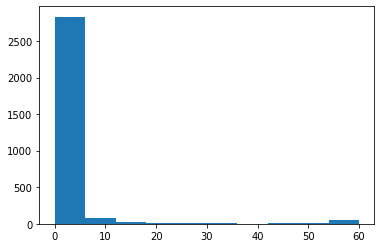

In [151]:
plt.hist(df_0['TIME_DELTA']);

Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_148 (LSTM)             (None, 5, 64)             16896     
                                                                 
 lstm_149 (LSTM)             (None, 32)                12416     
                                                                 
 dropout_74 (Dropout)        (None, 32)                0         
                                                                 
 dense_74 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
137/137 [==============================] - 2s 6ms/step - loss: 0.9761 - val_loss: 1.1499
Epoch 2/10
137/137 [==============================] - 1s 4ms/step - loss: 0.9713 

,t_0,t_1,t_2,t_3,t_4
0,0.147283,0.018350,9.450033,0.048133,0.269233
1,0.018350,9.450033,0.048133,0.269233,0.291733
2,9.450033,0.048133,0.269233,0.291733,8.760283
3,0.048133,0.269233,0.291733,8.760283,0.013567
4,0.269233,0.291733,8.760283,0.013567,18.916667
...,...,...,...,...,...
596,0.024300,0.458350,0.019267,0.308550,0.301817
597,0.458350,0.019267,0.308550,0.301817,8.077800
598,0.019267,0.308550,0.301817,8.077800,0.118217
599,0.308550,0.301817,8.077800,0.118217,0.340633


,y_test,y_pred
0,0.291733,1.808943
1,8.760283,1.790039
2,0.013567,2.047613
3,18.916667,1.734334
4,0.011667,2.392593
...,...,...
596,8.077800,1.286038
597,0.118217,1.584992
598,0.340633,1.700642
599,0.056000,1.745155


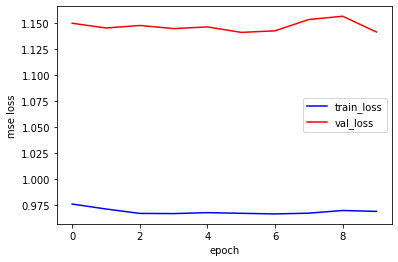

In [224]:
# importing necessary libraries
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

# defining training and testing sizes
test_size = 0.2
train_size = 1 - test_size
n_test = int(np.ceil(len(df_0) * test_size))
n_train = int(np.floor(len(df_0) * train_size))
train = df_0.loc[:n_train, ['TIME_DELTA', 'TIME_DELTA_1']].to_numpy().reshape(-1,2)
test = df_0.loc[n_train:, ['TIME_DELTA', 'TIME_DELTA_1']].to_numpy().reshape(-1,2)

# fitting scaler with training set
scaler = StandardScaler()
scaler.fit(train[:, 0].reshape(-1,1))
train = scaler.transform(train[:, 0].reshape(-1,1))
test = scaler.transform(test[:, 0].reshape(-1,1))
# train = train[:, 0].reshape(-1,1)
# test = test[:, 0].reshape(-1,1)
X_train, y_train = [], []
X_test, y_test = [], []

n_past = 5
n_future = 1
for i in range(n_past, len(train) - n_future + 1):
    X_train.append(train[i-n_past: i])
    y_train.append(train[i+n_future-1: i+n_future])
X_train, y_train = np.array(X_train), np.array(y_train)

for i in range(n_past, len(test) - n_future + 1):
    X_test.append(test[i-n_past: i])
    y_test.append(test[i+n_future-1: i+n_future])
X_test, y_test = np.array(X_test), np.array(y_test)

# splitting data into scaled training and testing sets
# X_train, y_train = scaler.transform(train[:, 0].reshape(-1,1)), scaler.transform(train[:, 1].reshape(-1,1))
# X_test, y_test = scaler.transform(test[:, 0].reshape(-1,1)), scaler.transform(test[:, 1].reshape(-1,1))
# X_train, y_train = train[:, 0].reshape(-1,1), train[:, 1].reshape(-1,1)
# X_test, y_test = test[:, 0].reshape(-1,1), test[:, 1].reshape(-1,1)

# defining model with 2 LSTM layers
model = keras.Sequential()
model.add(keras.layers.LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(keras.layers.LSTM(32, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1))

# defining optimizer and loss function
model.compile(optimizer='adam', loss='mse')
model.summary()

# fitting model
history = model.fit(X_train, y_train, batch_size=16, epochs=10, validation_split=0.1, shuffle=False)

# getting predictions
y_pred = model.predict(X_test)
stats = pd.DataFrame({'y_test': scaler.inverse_transform(y_test.reshape(-1,1)).flatten(), 'y_pred': scaler.inverse_transform(y_pred.reshape(-1,1)).flatten()})
# stats = pd.DataFrame({'X_test': X_test.flatten(), 'y_test': y_test.flatten(), 'y_pred': y_pred.flatten()})
display(pd.DataFrame({
    't_0': scaler.inverse_transform(X_test[:, 0]).flatten(),
    't_1': scaler.inverse_transform(X_test[:, 1]).flatten(), 
    't_2': scaler.inverse_transform(X_test[:, 2]).flatten(),
    't_3': scaler.inverse_transform(X_test[:, 3]).flatten(),
    't_4': scaler.inverse_transform(X_test[:, 4]).flatten()}))
display(stats)

# plotting training and validation losses
plt.plot(np.arange(10), history.history['loss'], label='train_loss', c='blue')
plt.plot(np.arange(10), history.history['val_loss'], label='val_loss', c='red')
plt.ylabel('mse loss');
plt.xlabel('epoch');
plt.legend();

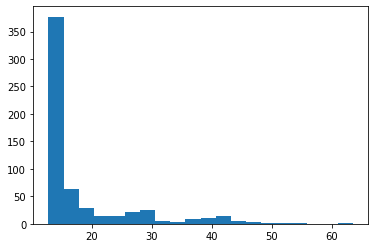

In [214]:
plt.hist(scaler.inverse_transform(stats['y_pred'].to_numpy().reshape(-1,1)), bins=20);

In [220]:
plt.hist(scaler.inverse_transform(stats['y_test'].to_numpy().reshape(-1,1)), bins=20);
y_test

array([[-0.22924558]])

### Problem 2b

***

In [ ]:
df = string_df_0[string_df_0['ID_INPUT'] == 3]
df.loc[:, 'MEASUREMENT_TIME'] = pd.to_datetime(df['MEASUREMENT_TIME'])
df.loc[:, 'TIME_DIFFERENCES'] = pd.Series()
times = df['MEASUREMENT_TIME']
for i in range(len(times)-1):
    df['TIME_DIFFERENCES'].iloc[i] = (pd.Timedelta(times.iloc[i+1] - times.iloc[i], 'milliseconds'))
df

***

In [ ]:
temp = string_df_0.copy()

In [ ]:
# getting only foreground application instances
foreground_0 = temp[temp['ID_INPUT'] == 3].reset_index(drop=True)

In [ ]:
# getting time differences between applications and adding column to DataFrame
time_0 = pd.to_datetime(foreground_0.iloc[:, 0]).reset_index(drop=True)
time_1 = pd.to_datetime(foreground_0.iloc[1:, 0]).append(pd.Series(np.nan)).reset_index(drop=True)
time_delta = (time_0 - time_1).apply(lambda x: -x.total_seconds())
foreground_0 = foreground_0.assign(**{'TIME_DELTA': time_delta})

# # removing outliers: applications that in the foreground for more than 3 hours straight
#####
foreground_0 = foreground_0[foreground_0['TIME_DELTA'] < 10800]

In [ ]:
time_delta.head()

In [ ]:
plt.figure(figsize=(15,6))
plt.hist(x=foreground_0['TIME_DELTA'], bins=25);
plt.title('Distribution of Foreground Application Times');
plt.xlabel('Time (minutes)');
plt.ylabel('Frequency');

In [ ]:
foreground_0.head()

In [ ]:
# foreground application time count, sum, mean, and std
stats = foreground_0.groupby(by=['VALUE']).agg(['count', 'sum', 'mean', 'std'])['TIME_DELTA']
stats

In [ ]:
# average foreground application time
means = stats['mean'].sort_values(ascending=False)

plt.figure(figsize=(20, 6))
# removing outlier: "startmenuexperiencehost.exe"
plt.bar(x=means.index[1:], height=means.values[1:])
plt.title('Average Foreground Application Time');
plt.xlabel('Application');
plt.ylabel('Time (minutes)');
plt.xticks(rotation=90);

In [ ]:
# cumulative foreground application time
sums = stats['sum'].sort_values(ascending=False)

plt.figure(figsize=(20, 6))
plt.bar(x=sums.index, height=sums.values)
plt.title('Cumulative Foreground Application Time');
plt.xlabel('Application');
plt.ylabel('Time (minutes)');
plt.xticks(rotation=90);

In [ ]:
plt.bar(x=foreground_0['MEASUREMENT_TIME'], height=foreground_0['TIME_DELTA'])

In [ ]:
output = foreground_0[['VALUE', 'TIME_DELTA']]
encoder = OrdinalEncoder()
output['VALUE'] = encoder.fit_transform(output[['VALUE']])
output.head()

In [ ]:
output.to_csv('problem_2.csv', index=False, header=False)